# Twitter Project

In [1]:
!pip install gensim python-twitter matplotlib wordcloud --upgrade

     |████████████████████████████████| 24.1 MB 1.3 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 11.2 MB 44.4 MB/s 
     |████████████████████████████████| 366 kB 55.0 MB/s 
     |████████████████████████████████| 890 kB 43.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5,

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


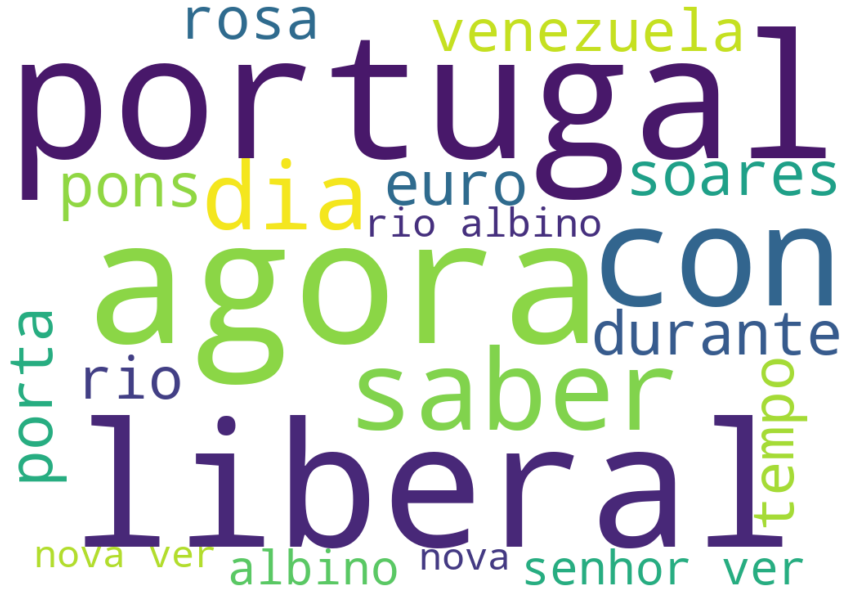

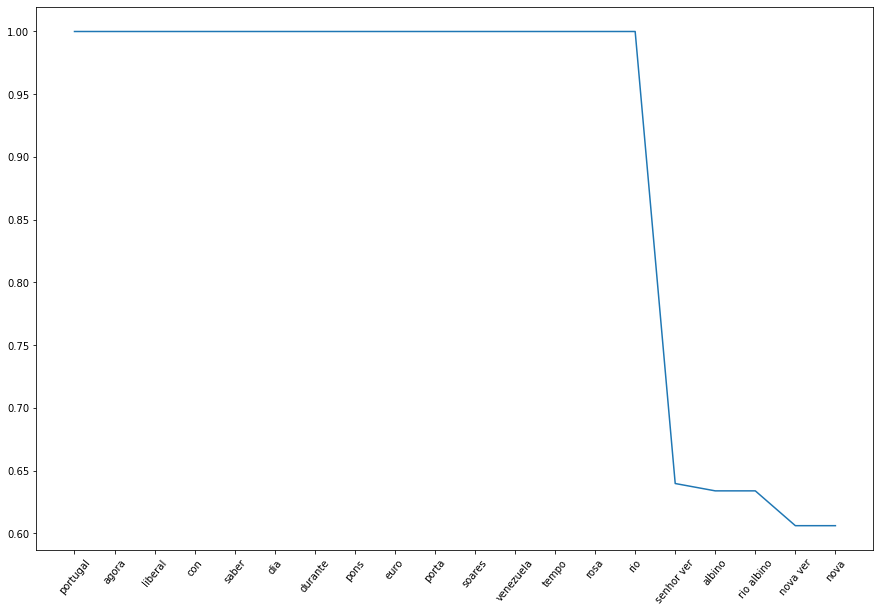

In [1]:
import twitter

import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from gensim.corpora import Dictionary
from gensim.models import TfidfModel

import matplotlib.pyplot as plt

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Define the search term
term = 'antonio costa'

# Define tokenizer and stop words
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('portuguese'))
stop_words.update(set(stopwords.words('english')))
stop_words.add('https')

# Add the search term to the stop word list
for t in term.split():
    stop_words.add(t.lower())

def generate_ngrams(tokens, n=2):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]
    
def scores(vectorizer, tfidf_result, limit=10):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:limit]

def display_scores(vectorizer, tfidf_result):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores:
        print ('{0:50} Score: {1}'.format(item[0], item[1]))

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w.lower() for w in tokens if not w in stop_words and w.isalpha() and len(w) > 2]
    tokens = [lemmatizer.lemmatize(w) for w in tokens if wordnet.synsets(w)]
    bigrams = generate_ngrams(tokens)
    return tokens + bigrams
    #return tokens

api = twitter.Api(consumer_key='2lDgkNXdm03bxodf55vlY5IHo',
                  consumer_secret='w5SaNzPCLyaBL1ieyGpm4uwjan5Y2GDqQjbbSUoBTT5Fl3cLP4',
                  access_token_key='276620312-0oyEjiC76ouJXCWALH5P9L3NXHSQ7kPw75jL9wse',
                  access_token_secret='HuJgudHMikT6VGd13M79GkXf0IdzDw20xyePaM8gHRJgg')

results = api.GetSearch(term=term, count=300)

corpus = []
for r in results:
    corpus.append(tokenize(r.text.lower()))
    
# Build the dictionary
dictionary = Dictionary(corpus) 

# Convert to vector corpus
vectors = [dictionary.doc2bow(text) for text in corpus]

# Build TF-IDF model
tfidf = TfidfModel(vectors)

# Get TF-IDF weights
weights = [tfidf[v] for v in vectors]
weights = [item for sublist in weights for item in sublist]
weights = list(set(weights))

# Replace term IDs with human consumable strings
weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
weights.sort(key=lambda p: p[1], reverse=True)

# Select only k top words
weights = weights[:20]

# Create the dictionary of frequencies
frequencies = {}
for p in weights:
    frequencies[p[0]] = p[1]

# Initialize the cloud
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width=1024,
    height=720,
    stopwords=stop_words
)

# Generate the cloud
wordcloud = wc.generate_from_frequencies(frequencies)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Display a chart with the distribution of weights from the words
x = [v[1] for v in weights]
labels = [v[0] for v in weights]

plt.figure(figsize=(15,10))
plt.xticks(range(0, len(x)), labels=labels, rotation=50)
plt.plot(x)
plt.show()